In [1]:
import hist
import numpy as np
import matplotlib.pyplot as plt

In [2]:
h = hist.Hist(
    hist.axis.Regular(50, -4, 4, name="S", title="s [units]", underflow=False, overflow=False)
)

data = np.random.normal(size=1_000)

h.fill(data)

Hist(Regular(50, -4, 4, underflow=False, overflow=False, metadata={'name': 'S', 'title': 's [units]'}), storage=Double()) # Sum: 1000.0

In [3]:
def pdf(x, a=1/np.sqrt(2*np.pi), x0=0, sigma=1, offset=0):
    return a * np.exp(-(x-x0)**2/(2*sigma**2)) + offset

/Users/nino/Documents/GitHub/hist/src/hist/general.py:29: RuntimeWarning: divide by zero encountered in true_divide
  pulls = (self.view() - values) / yerr


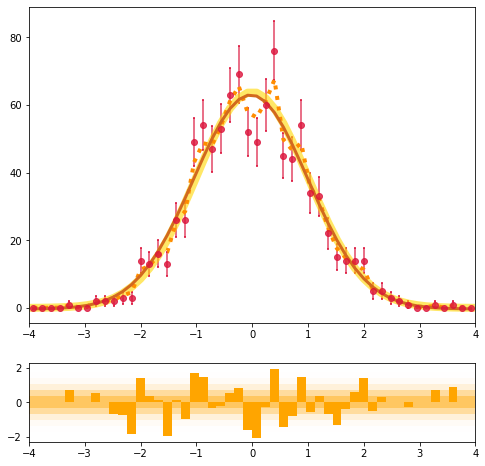

In [5]:
h.pull_plot(pdf, eb_ecolor='crimson', eb_mfc='crimson', eb_mec='crimson', eb_fmt='o', eb_ms=6,\
                eb_capsize=1, eb_capthick=2, eb_alpha=.8, vp_c='gold', vp_ls='-', vp_lw=8,\
                vp_alpha=.6, mp_c='darkorange', mp_ls=':', mp_lw=4, mp_alpha=1.,\
                fp_c='chocolate', fp_ls='-', fp_lw=3, fp_alpha=1., bar_fc='orange',\
                pp_num=6, pp_fc='orange', pp_alpha=.618, pp_ec=None)
plt.show()

/Users/nino/Documents/GitHub/hist/src/hist/general.py:29: RuntimeWarning: divide by zero encountered in true_divide
  pulls = (self.view() - values) / yerr


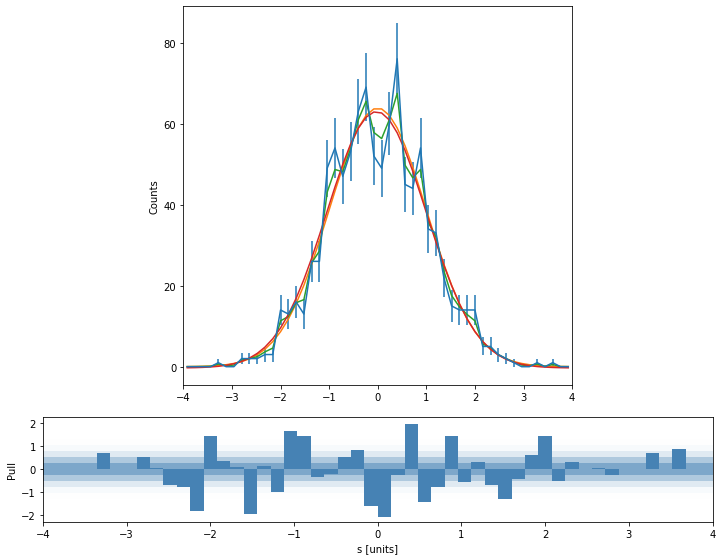

In [8]:
fig = plt.figure(figsize=(12, 12))
grid = fig.add_gridspec(5, 5, wspace=0.3, hspace=0.3)
ax = fig.add_subplot(grid[0:3, 1:4])
pull_ax = fig.add_subplot(grid[3:4, :], sharex=ax)

fig, ax, pull_ax = h.pull_plot(pdf, fig=fig, ax=ax, pull_ax=pull_ax, bar_fc='steelblue',\
                pp_fc='steelblue', pp_num=8, pp_alpha=.7)

ax.set_ylabel("Counts")
pull_ax.set_xlabel(h.axes[0].title)
pull_ax.set_ylabel("Pull")
plt.show()